# 基于YOLOV5的车俩目标检测
## 基本原理
Yolo 的全称是 **you only look once**，指只需要浏览一次就可以识别出图中的物体的类别和位置。<p>
而Yolov5 就是一个是用于目标检测的模型。简单来讲就是是在一张图片中找出物体，并给出它的类别和位置。<p>
目标检测是基于监督学习的，每张图片的监督信息是它所包含的N个物体，每个物体的信息有五个，分别是物体的中心位置(x,y)和它的高(h)和宽(w)，最后是它的类别。<p>
Yolo 模型的预测是基于整个图片的，并且它会一次性输出所有检测到的目标信息，包括类别和位置。<p>

In [1]:
!unzip -n /data/bigfiles/test.zip

Archive:  /data/bigfiles/test.zip
   creating: .github/
  inflating: .github/CODE_OF_CONDUCT.md  
  inflating: .github/dependabot.yml  
   creating: .github/ISSUE_TEMPLATE/
  inflating: .github/ISSUE_TEMPLATE/bug-report.yml  
  inflating: .github/ISSUE_TEMPLATE/config.yml  
  inflating: .github/ISSUE_TEMPLATE/feature-request.yml  
  inflating: .github/ISSUE_TEMPLATE/question.yml  
  inflating: .github/PULL_REQUEST_TEMPLATE.md  
  inflating: .github/README_cn.md    
  inflating: .github/SECURITY.md     
   creating: .github/workflows/
  inflating: .github/workflows/ci-testing.yml  
  inflating: .github/workflows/codeql-analysis.yml  
  inflating: .github/workflows/docker.yml  
  inflating: .github/workflows/greetings.yml  
  inflating: .github/workflows/stale.yml  
   creating: __pycache__/
  inflating: __pycache__/export.cpython-36.pyc  
  inflating: __pycache__/export.cpython-37.pyc  
  inflating: __pycache__/val.cpython-36.pyc  
  inflating: __pycache__/val.cpython-37.pyc  
   creati

## 基本流程
1. 从github上clone下YOLOV5框架源码, 下载地址:https://github.com/ultralytics/yolov5.git
2. 准备好自己的数据集, 包括打标签、将标签文件转为yolo需要的txt形式,划分训练集测试集等
3. 安装环境所需的依赖包, 编写属于自己训练集的yaml配置文件
4. 配置train.py的参数,包括epoch、batchsize等参数
5. 训练完成后, 在runs下查看模型的训练效果
6. 运行detect.py测试训练效果


## 数据集说明
Pascal VOC challenge是一个非常流行的数据集，用于构建和评估用于图像分类、对象检测和分割的算法。
这个挑战的目标是在现实场景中从大量的可视对象类中识别对象(即不是预先分割的对象)。有20个对象类：
VOC数据集主要分为：VOC2007、VOC2012, 此实训使用到的是VOC2007数据集进行人车物体检测实验。
数据集下载地址为： https://pjreddie.com/projects/pascal-voc-dataset-mirror/

格式介绍：
下载VOC数据集，解压后，文件夹内容如下：
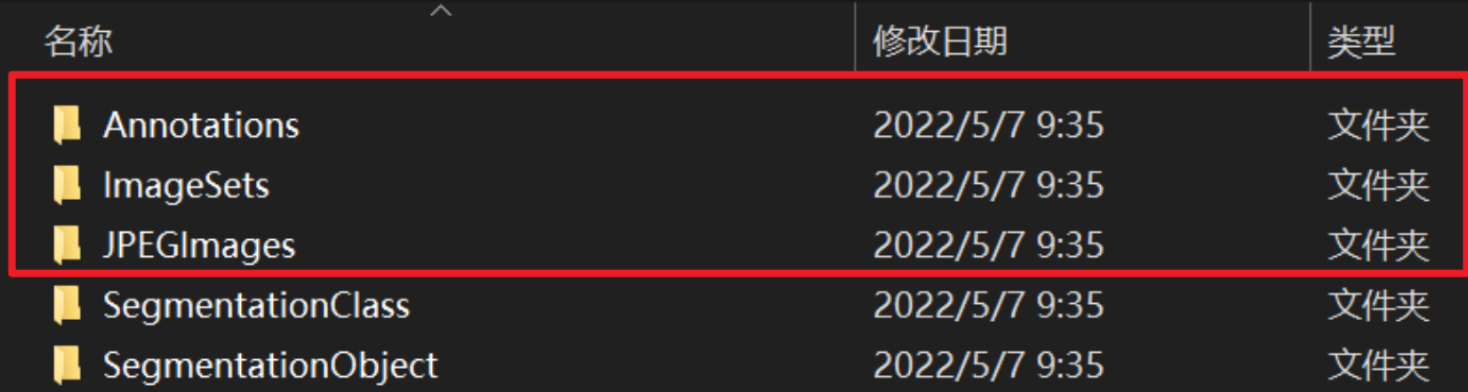<p>

一般目标检测只需用到Annotations、ImageSets、JPEGImages这3个文件夹，剩下的可以删掉。
Annotations：存放所有图片的标注xml文件；
ImageSets：文件夹下有3个子文件夹：Layout、Main、Segmentation，我们只用到Main文件夹，其他可以删掉。下面看一下Main文件夹下的内容：
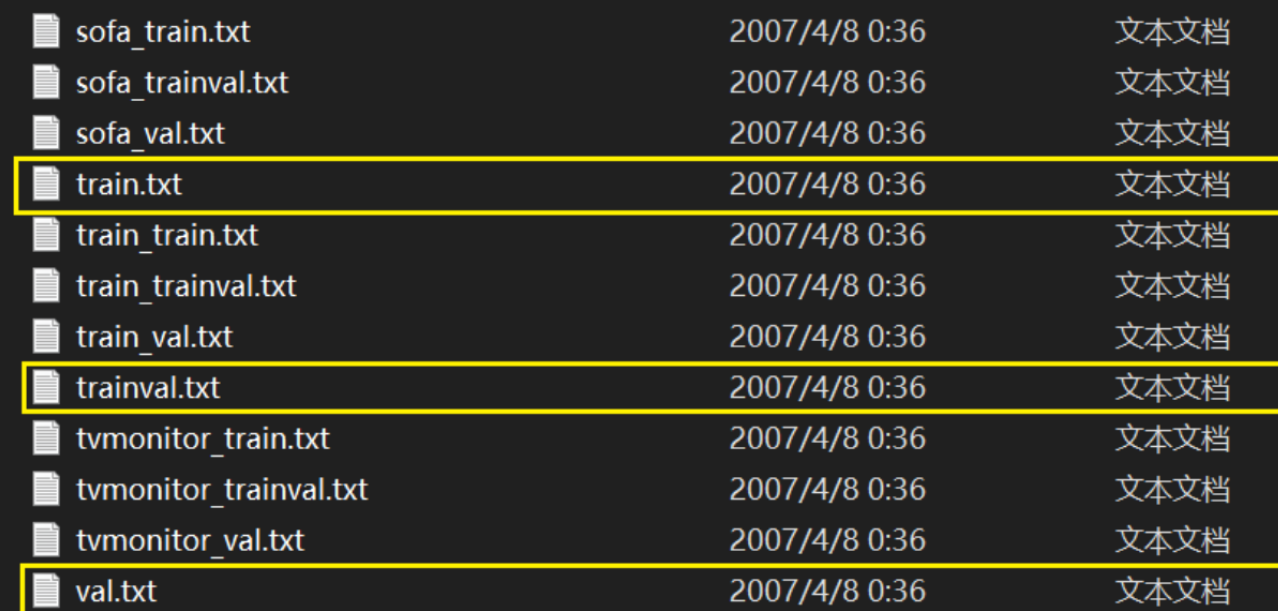

Main文件夹下有20个类别的×××_train.txt、×××_trainval.txt、×××_val.txt（其实删掉也可以，不影响）。我们只要保留并关注三个文件（黄色框）：train.txt、val.txt、trainval.txt (训练集、验证集、训练集加验证集总和）。其实可以把Main文件夹下内容全删了，只留空文件夹，因为一般我们都是自己划分。（什么时候删除还是保留，在下面会说）
JPEGImages:存放所有的图片，图片顺序及名称和xml文件是一一对应的。

## VOC数据集划分和转YOLO格式处理
YOLOv5训练用的是COCO数据集，并且yolo的数据格式和VOC格式有不同。VOC是通过xml文件读取数据，yolo是通过txt文件读取数据（类别和坐标信息）。
在 VOCdevkit 目录下创建split_train_val.py，运行之后会在Main文件夹下生成3个txt文件：train.txt、val.txt、test.txt

In [2]:
!python split_train_val.py
!ls voc_data/VOC2007/Main

test.txt  train.txt  val.txt


运行代码后,在Main文件夹下生成下面3个txt文档, 每个文档包含着对应训练集/测试集的图片名字:
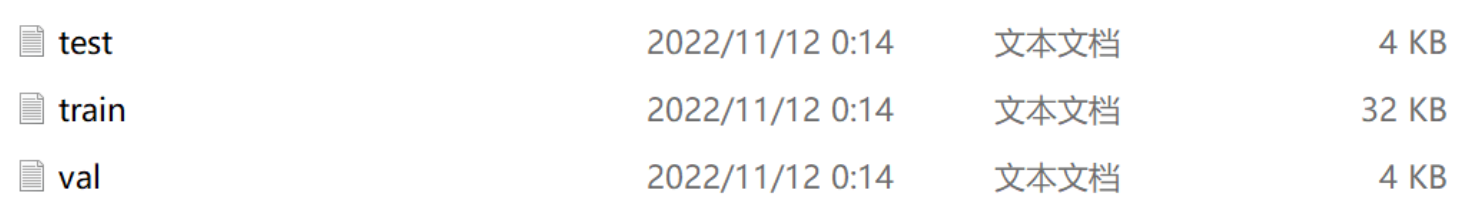

接下来准备labels，把数据集格式转换成yolo_txt格式，即将每个xml标注提取bbox信息为txt格式（这种数据集格式成为yolo_txt格式），每个图像对应一个txt文件，文件每一行为一个目标的信息，包括class, x_center, y_center, width, height格式。格式如下：
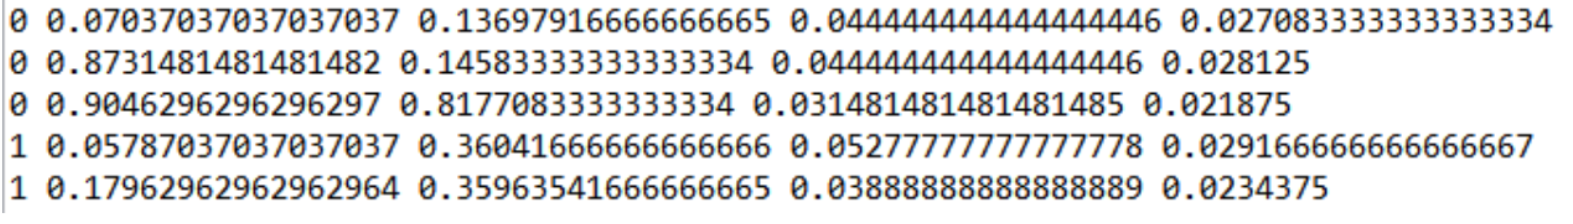

**由于我们只需要用到VOC2007数据集中的公交车和轿车数据集，所以在下面的classes列表中只需保留 car,bus  参数即可。**

In [6]:
# -*- coding: utf-8 -*-
import xml.etree.ElementTree as ET
import os
from os import getcwd

sets = ['train', 'val', 'test']
classes = ['bus','car']
abs_path = os.getcwd()
print(abs_path)

def convert(size, box):
    dw = 1. / (size[0])
    dh = 1. / (size[1])
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h


def convert_annotation(image_id):
    in_file = open('voc_data/VOC2007/Annotations/%s.xml' % (image_id), encoding='UTF-8')
    # print(in_file)
    out_file = open('voc_data/VOC2007/labels/%s.txt' % (image_id), 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    # print(root.find('object'))

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        # difficult = obj.find('Difficult').text
        cls = obj.find('name').text
        # print(difficult,obj)
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
             float(xmlbox.find('ymax').text))
        b1, b2, b3, b4 = b
        print(b)
        # 标注越界修正
        if b2 > w:
            b2 = w
        if b4 > h:
            b4 = h
        b = (b1, b2, b3, b4)
        bb = convert((w, h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for image_set in sets:
    if not os.path.exists('voc_data/VOC2007/labels/'):
        os.makedirs('voc_data/VOC2007/labels/')
    image_ids = open('voc_data/VOC2007/ImageSets/Main/%s.txt' % (image_set)).read().strip().split()
    # print(image_ids)
    if not os.path.exists('voc_data/VOC2007/dataSet_path/'):
        os.makedirs('voc_data/VOC2007/dataSet_path/')

    list_file = open('voc_data/VOC2007/dataSet_path/%s.txt' % (image_set), 'w')
    # 这行路径不需更改，这是相对路径
    for image_id in image_ids:
        # print(image_id)
        list_file.write('voc_data/VOC2007/images/%s.jpg\n' % (image_id))
        # print(image_id)
        convert_annotation(image_id)
    list_file.close()


/data/workspace/myshixun_tpm284289/bnzurlkf
(372.0, 400.0, 102.0, 123.0)
(351.0, 376.0, 101.0, 124.0)
(68.0, 284.0, 324.0, 498.0)
(2.0, 500.0, 50.0, 314.0)
(1.0, 149.0, 247.0, 418.0)
(411.0, 500.0, 183.0, 212.0)
(459.0, 500.0, 146.0, 246.0)
(3.0, 242.0, 2.0, 178.0)
(58.0, 119.0, 283.0, 329.0)
(1.0, 450.0, 1.0, 337.0)
(1.0, 476.0, 47.0, 351.0)
(128.0, 426.0, 90.0, 266.0)
(1.0, 472.0, 46.0, 351.0)
(150.0, 462.0, 102.0, 236.0)
(374.0, 477.0, 1.0, 29.0)
(369.0, 475.0, 103.0, 283.0)
(33.0, 369.0, 46.0, 330.0)
(217.0, 452.0, 166.0, 280.0)
(1.0, 199.0, 171.0, 290.0)
(355.0, 385.0, 1.0, 20.0)
(34.0, 457.0, 61.0, 320.0)
(61.0, 125.0, 168.0, 202.0)
(458.0, 491.0, 210.0, 237.0)
(17.0, 472.0, 165.0, 282.0)
(72.0, 150.0, 343.0, 376.0)
(192.0, 280.0, 337.0, 380.0)
(144.0, 397.0, 133.0, 322.0)
(1.0, 185.0, 124.0, 209.0)
(375.0, 433.0, 142.0, 176.0)
(250.0, 343.0, 178.0, 215.0)
(150.0, 266.0, 223.0, 311.0)
(325.0, 500.0, 240.0, 375.0)
(1.0, 454.0, 77.0, 281.0)
(27.0, 500.0, 120.0, 314.0)
(92.0, 408.0,

运行后在**voc_data/VOC2007/dataSet_path**会生成如下labels文件夹和三个包含数据集的txt文件，其中labels中为不同图像的标注文件，<p>train.txt等txt文件为划分后图像所在位置的绝对路径，三个txt文件里面的内容如下所示：<p>
   
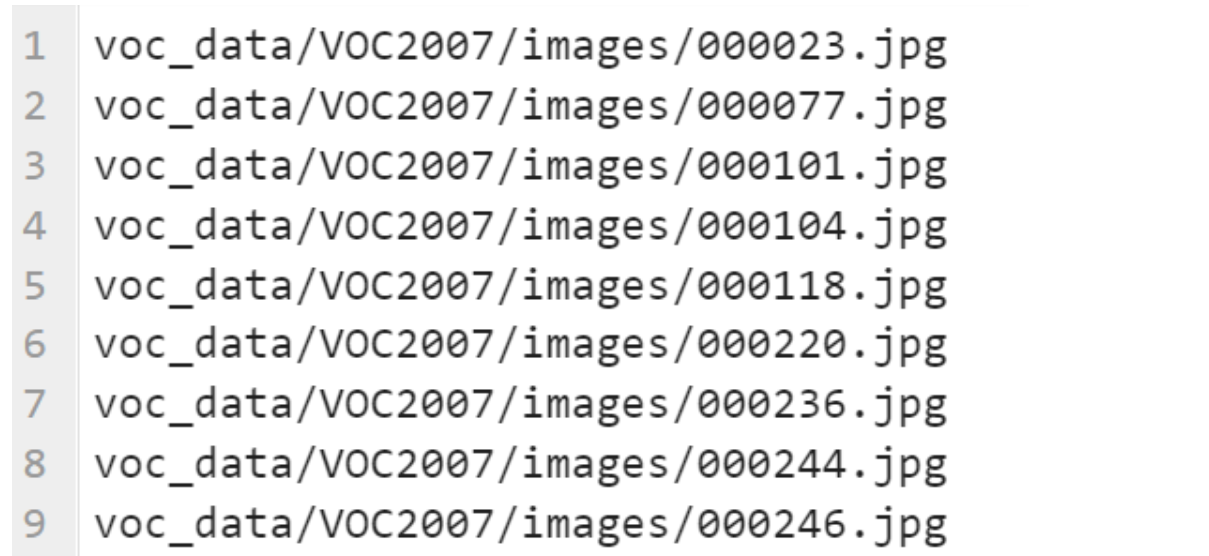

## 配置YoloV5环境
从github上clone下YOLOV5框架源码, 下载地址:https://github.com/ultralytics/yolov5.git <p>
### 安装依赖包：
本地电脑可以跳过这一步！！！

In [8]:
!apt-get updateb
!apt-get install sudo
!sudo apt install libgl1-mesa-glx -y

E: Invalid operation updateb
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package sudo
/bin/sh: 1: sudo: not found


### 目录结构
目录结构如下，将之前labelImg标注好的xml文件和图片放到对应目录下<p>
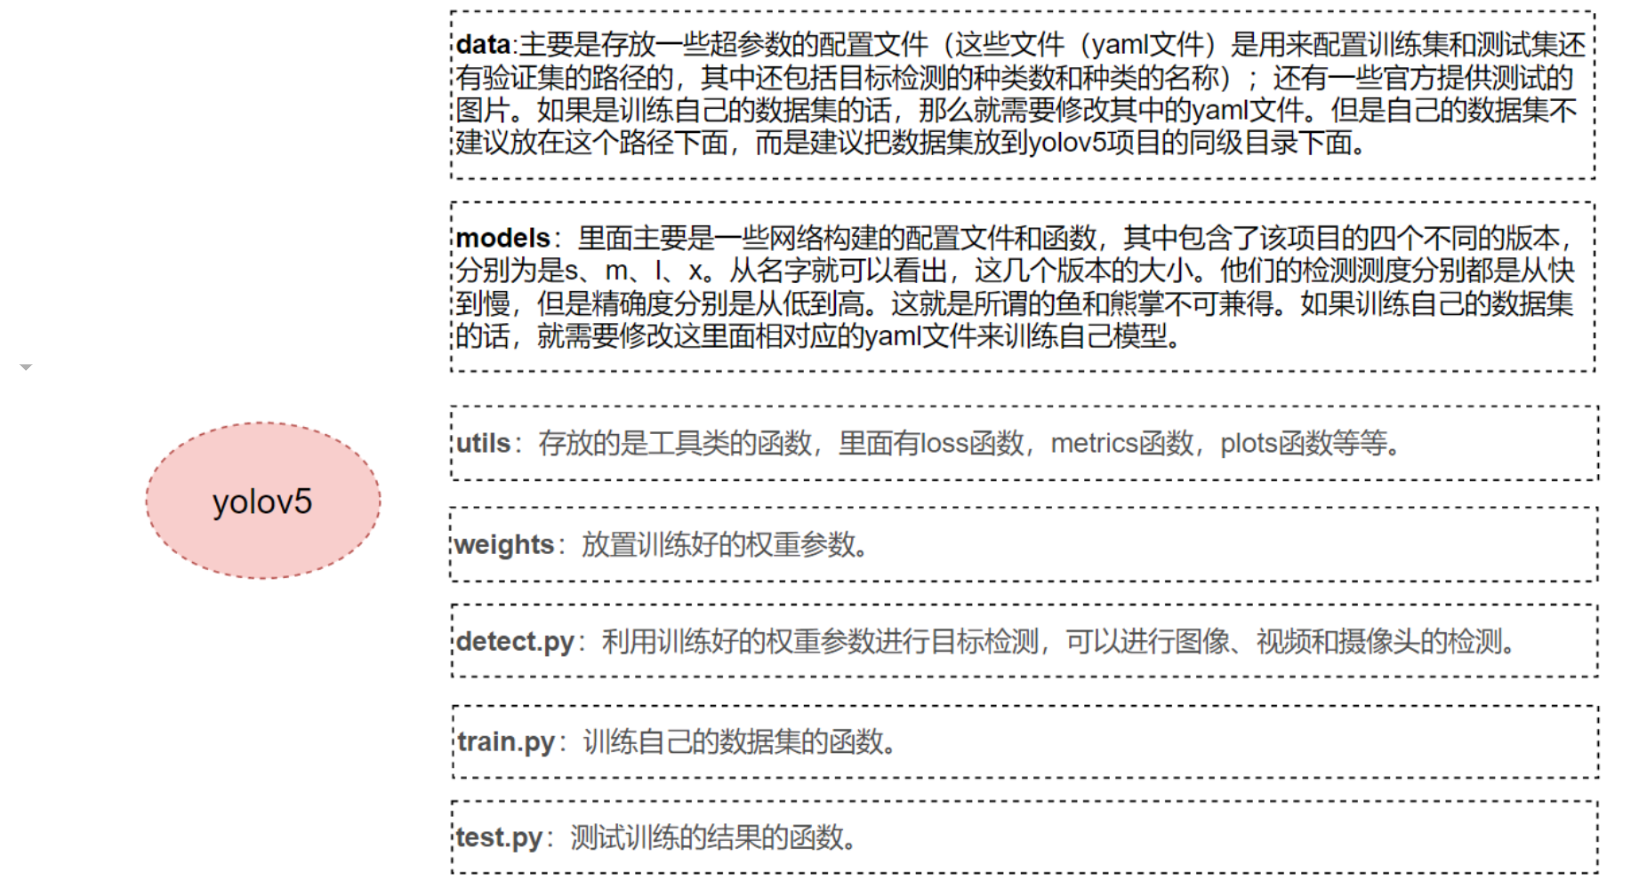

### 修改voc.yaml文件
yolov5下 train.py 默认使用的是coco.yaml训练的，自己新建一个适用VOC数据集训练的my_voc.yaml。
首先，修改nc和names的内容，nc：代表自己数据集有多少类，names：代表自己数据集的类的名字；
然后，修改在新建voc.yaml下修改 train 和 val 后面的路径（我这里没用test测试集），改成新生成的 train.txt 和 val.txt 路径地址（注意：不是Main文件夹下的，是上面第3步新生成的！别搞错了！！！ 还有一点，下图红色框部分，改路径地址的时候，两个冒号后面跟路径地址之间要有一个空格！）
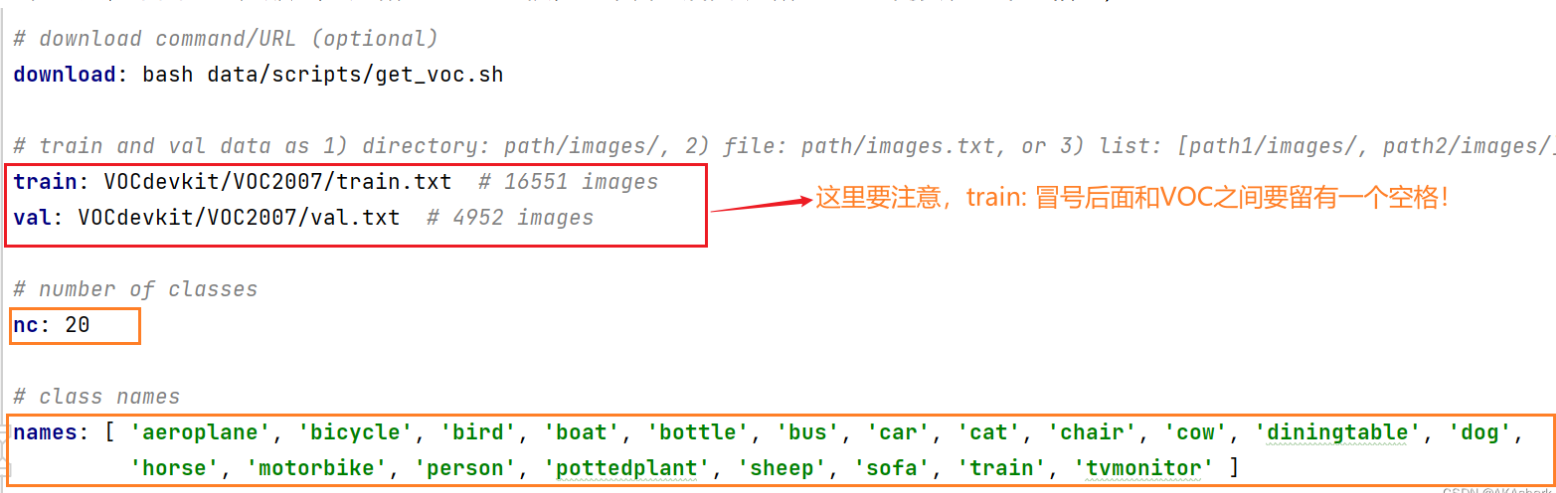

## 模型训练
对train.py进行修改，选择预训练权重，epochs根据自己情况设置；batch-size需要显存，显存小就设置低点。
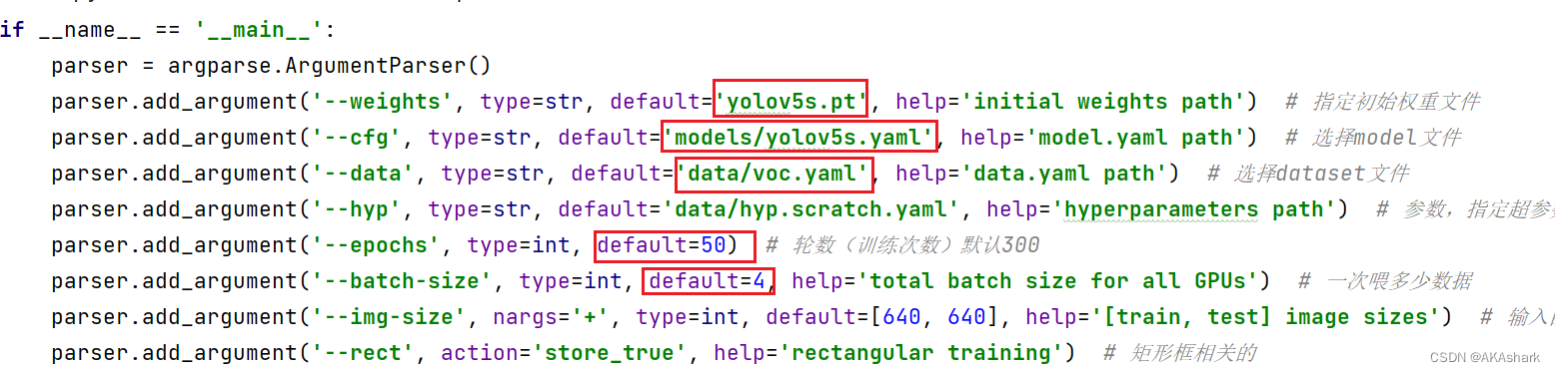


**由于数据集过大，建议跳过此步！！！**

In [10]:
# !python train.py

## 模型效果展示
保存的模型效果,如混淆矩阵、ROC曲线、测试结果图等等都保存在***runs\train\exp***下, <p>
保存的训练模型存放在***runs\train\exp\weights***下, ***best.pt***是所有迭代中效果最好的模型, ***last.pt***是最后一次迭代的模型<p>
这里展示迭代了十次的模型效果:<p>
混淆矩阵图: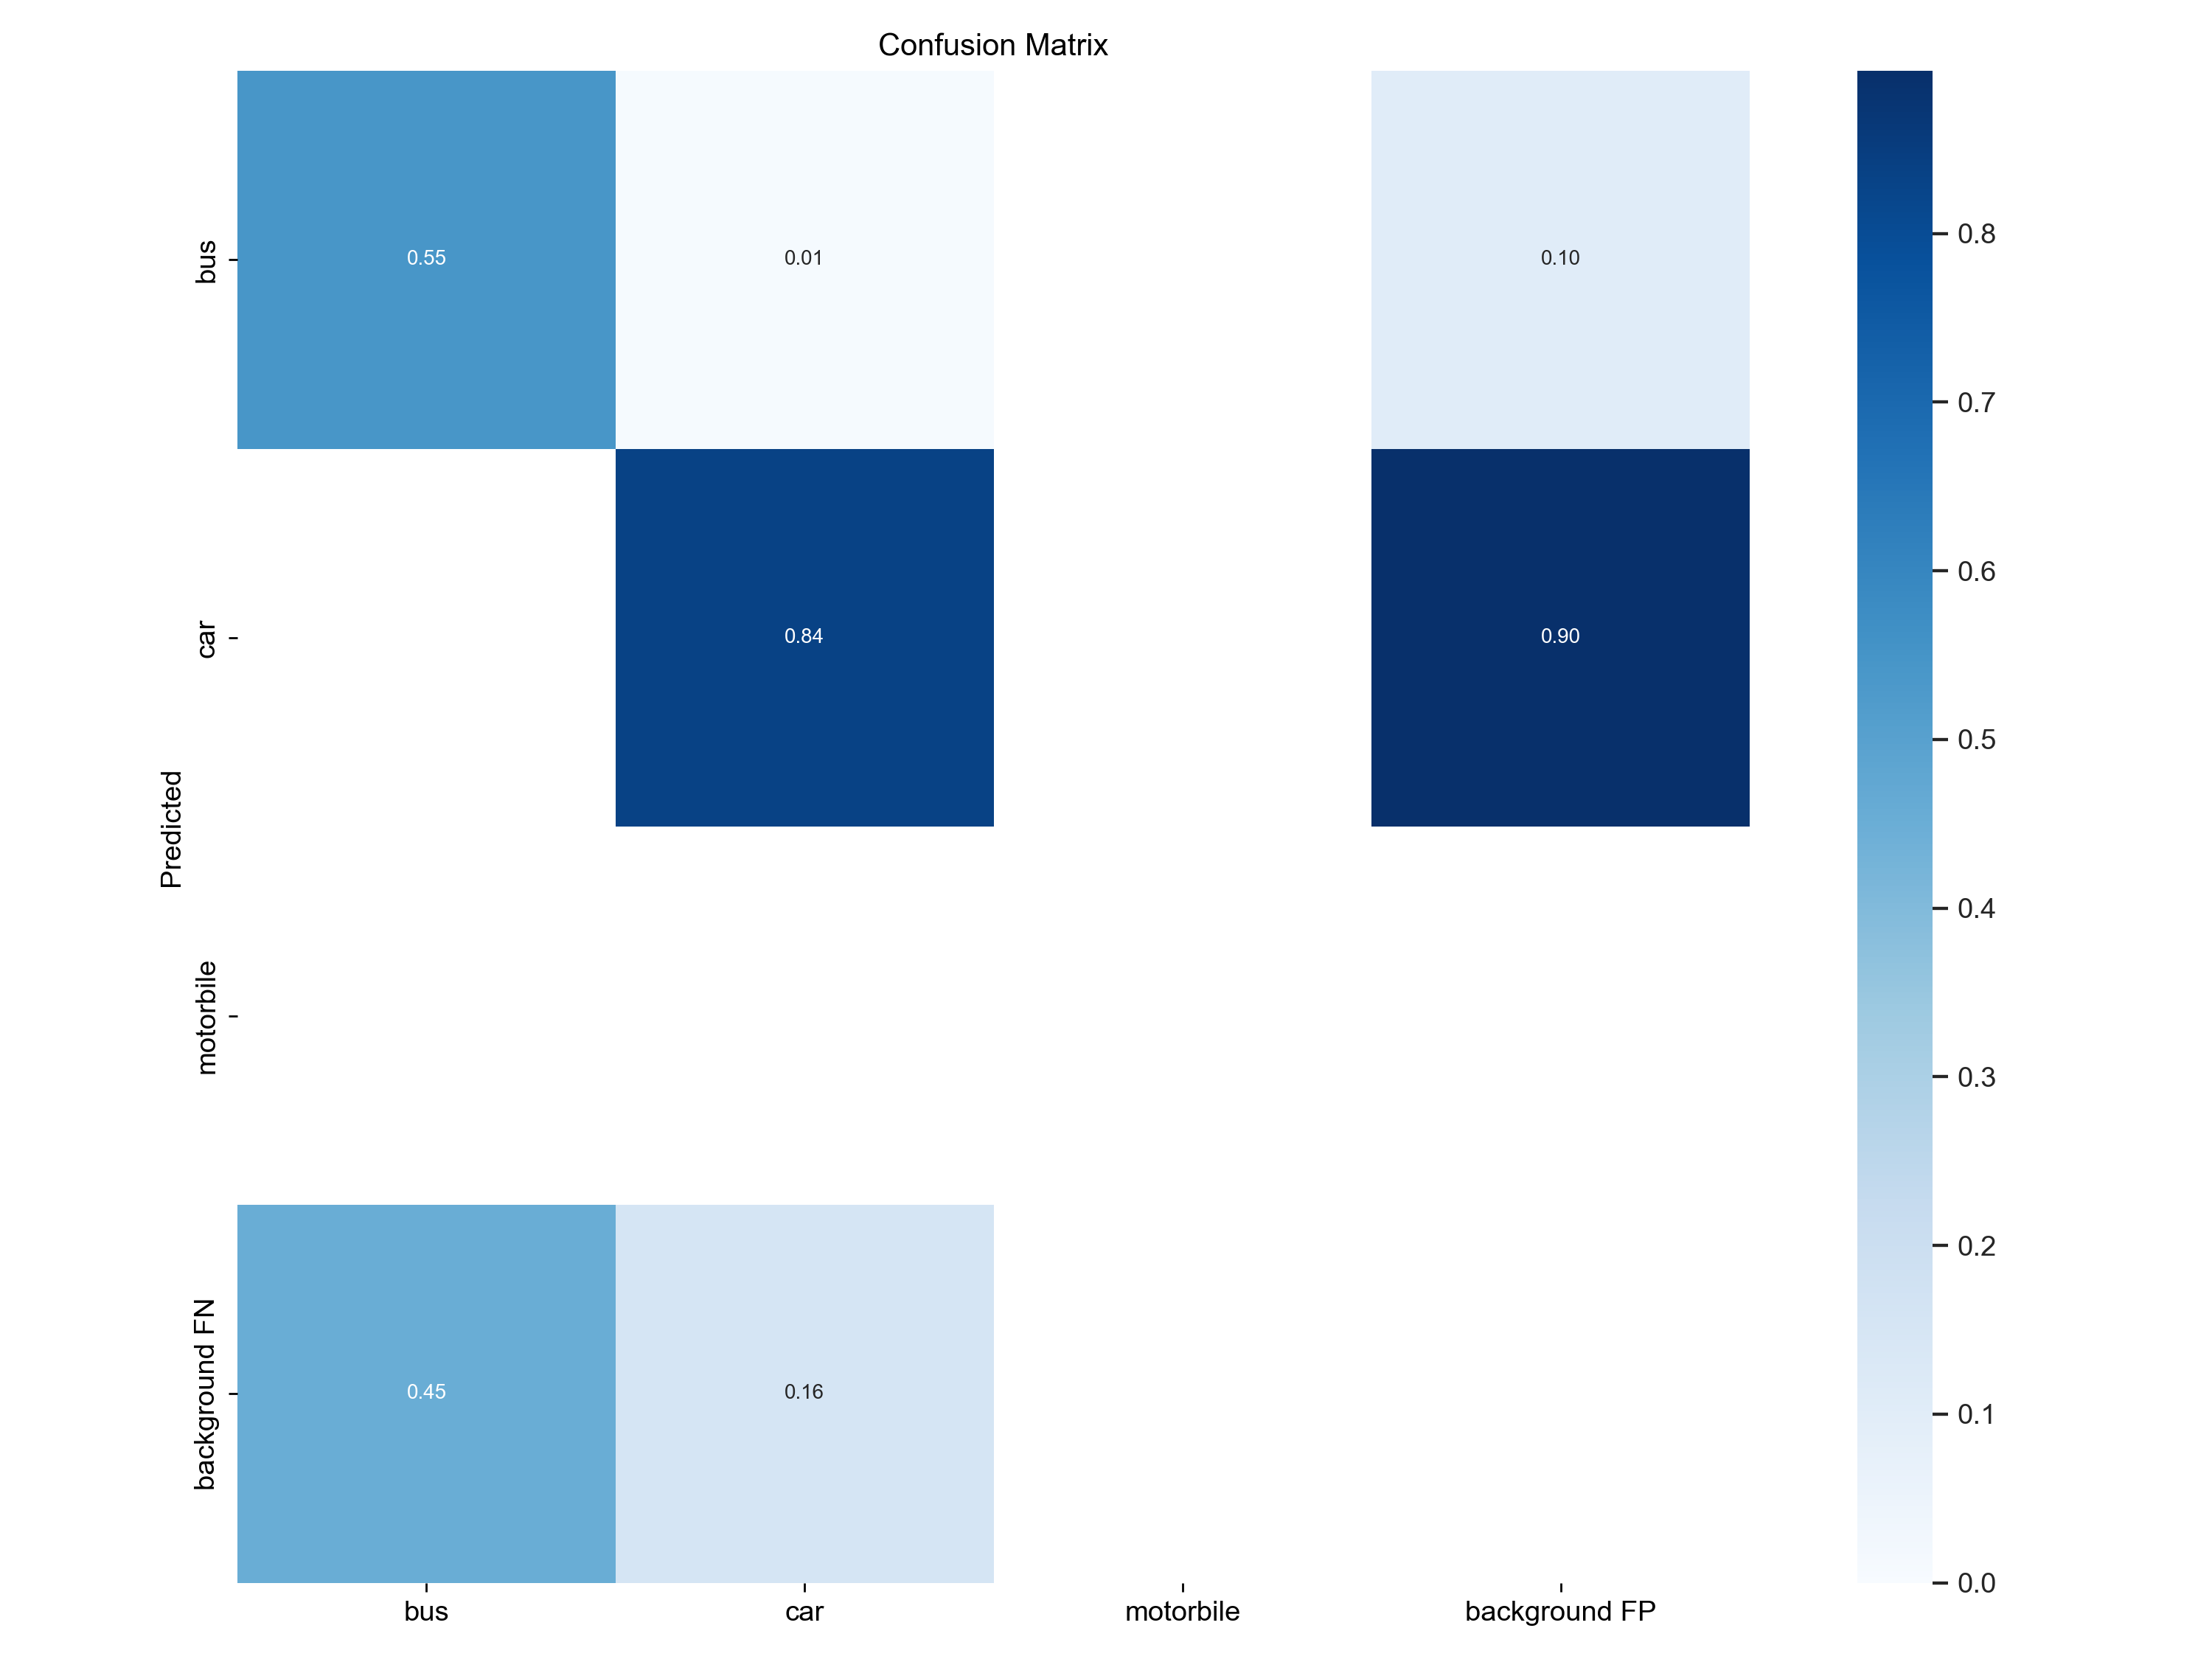  <p>
F1曲线图: 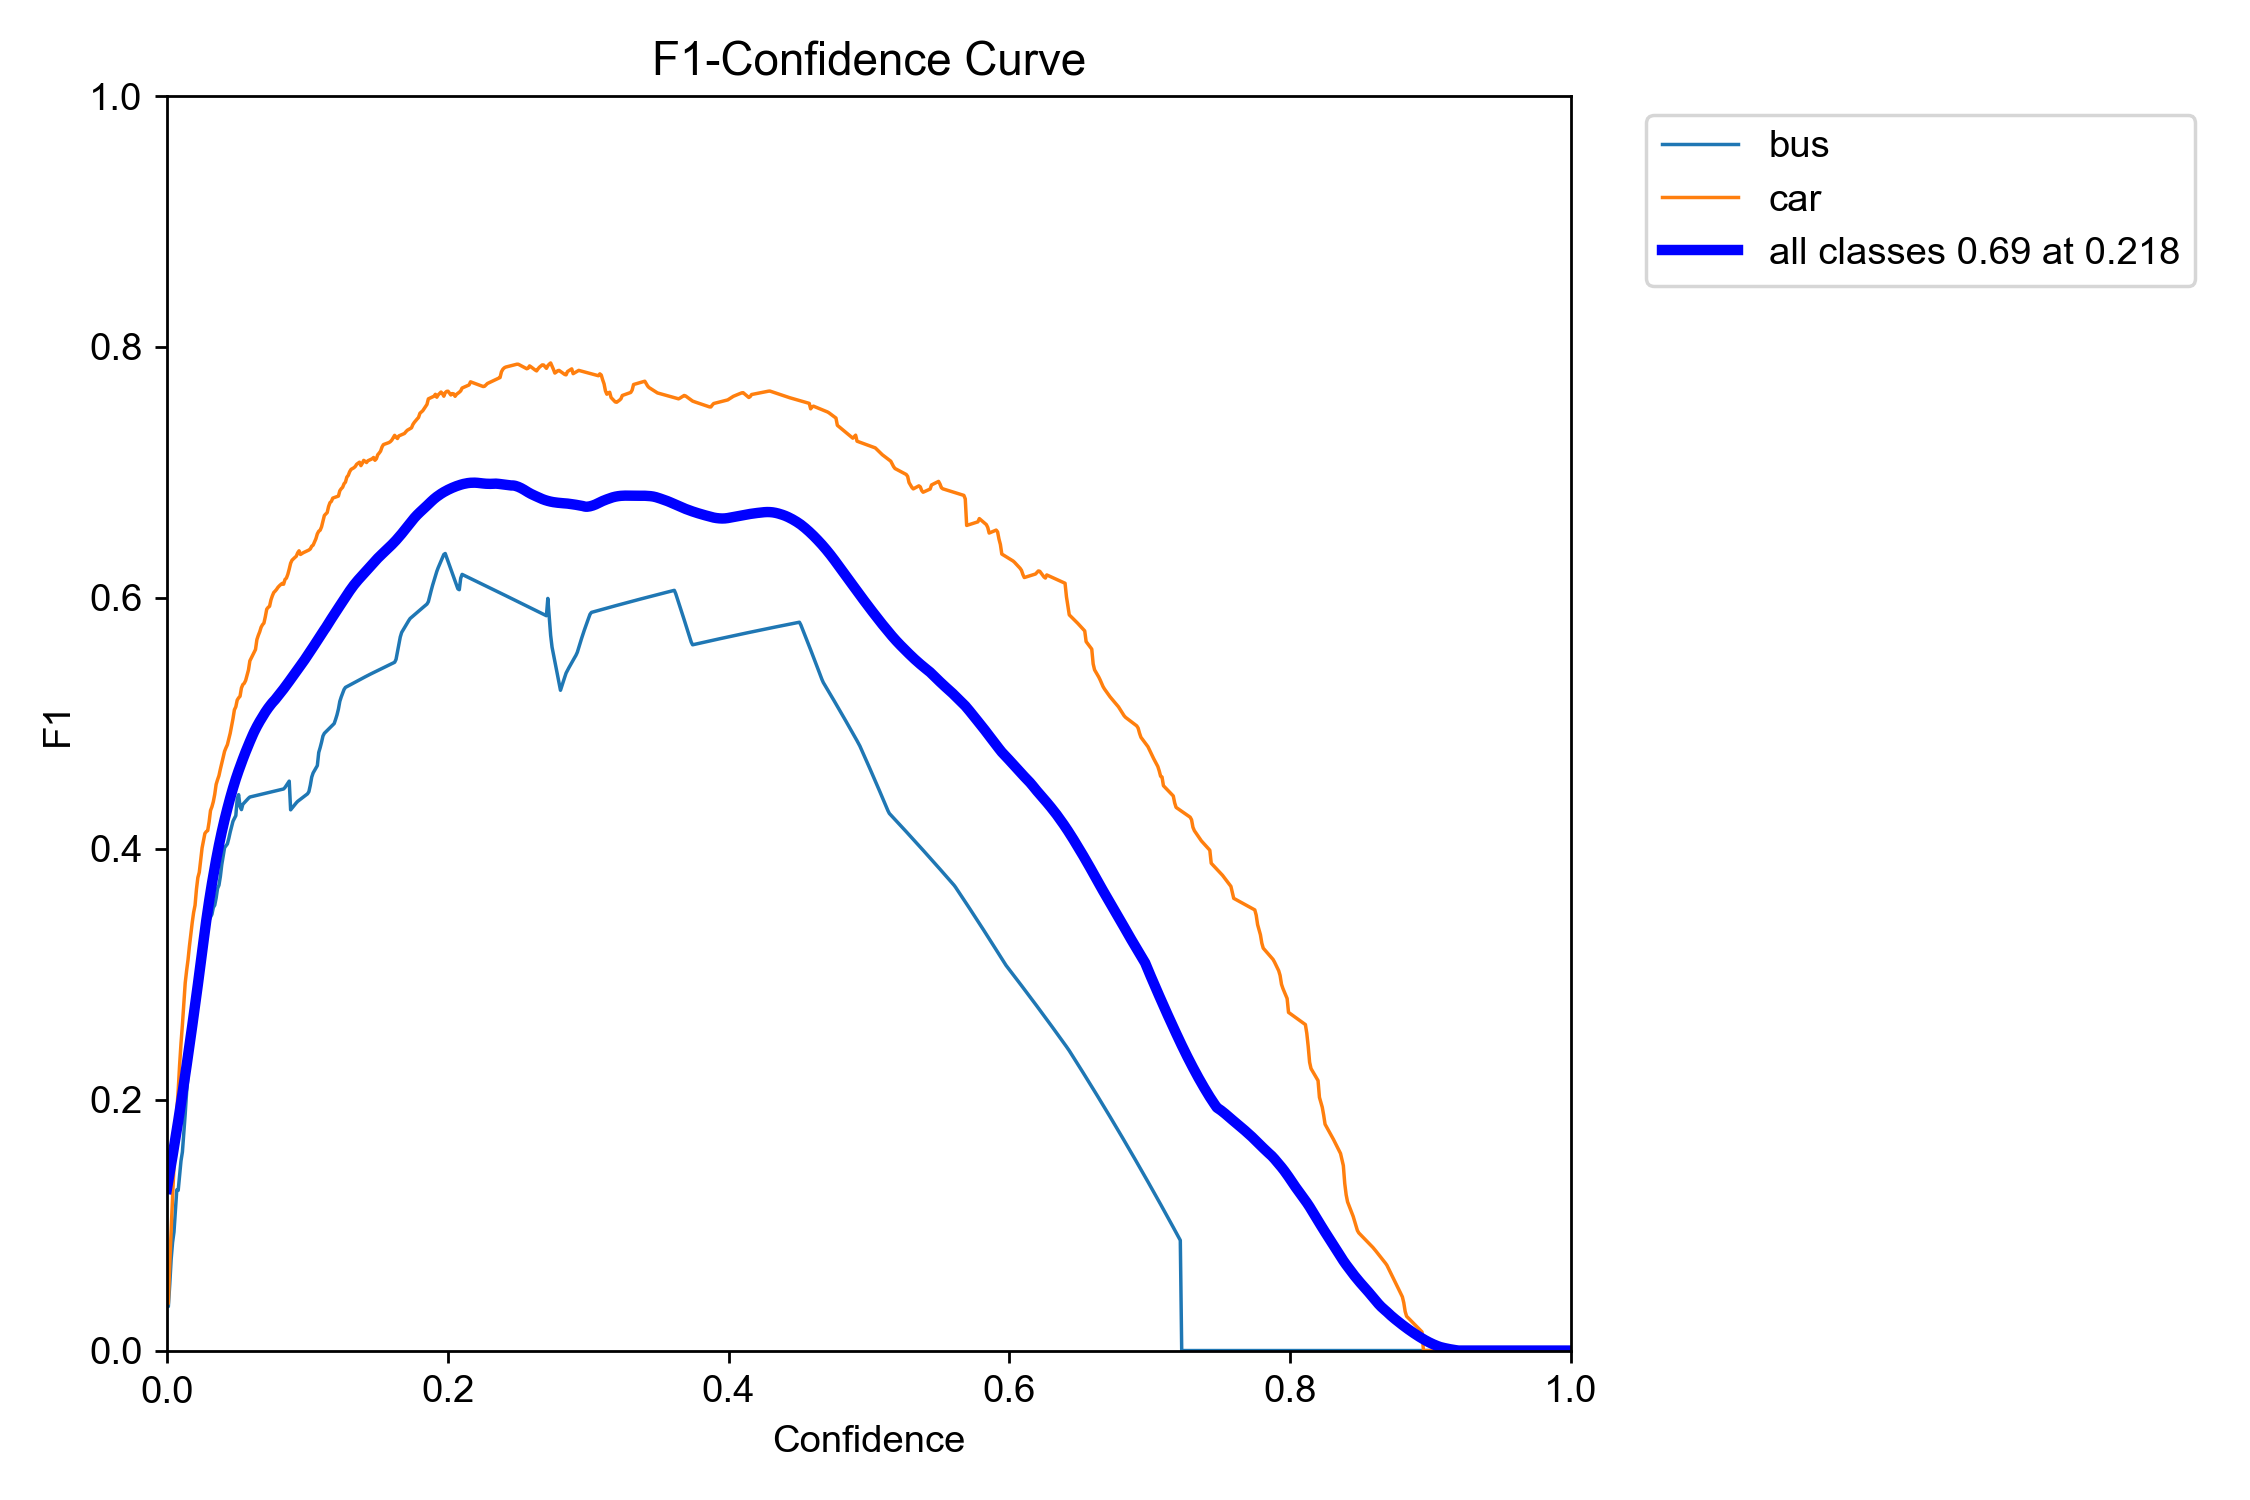
损失和精度图: 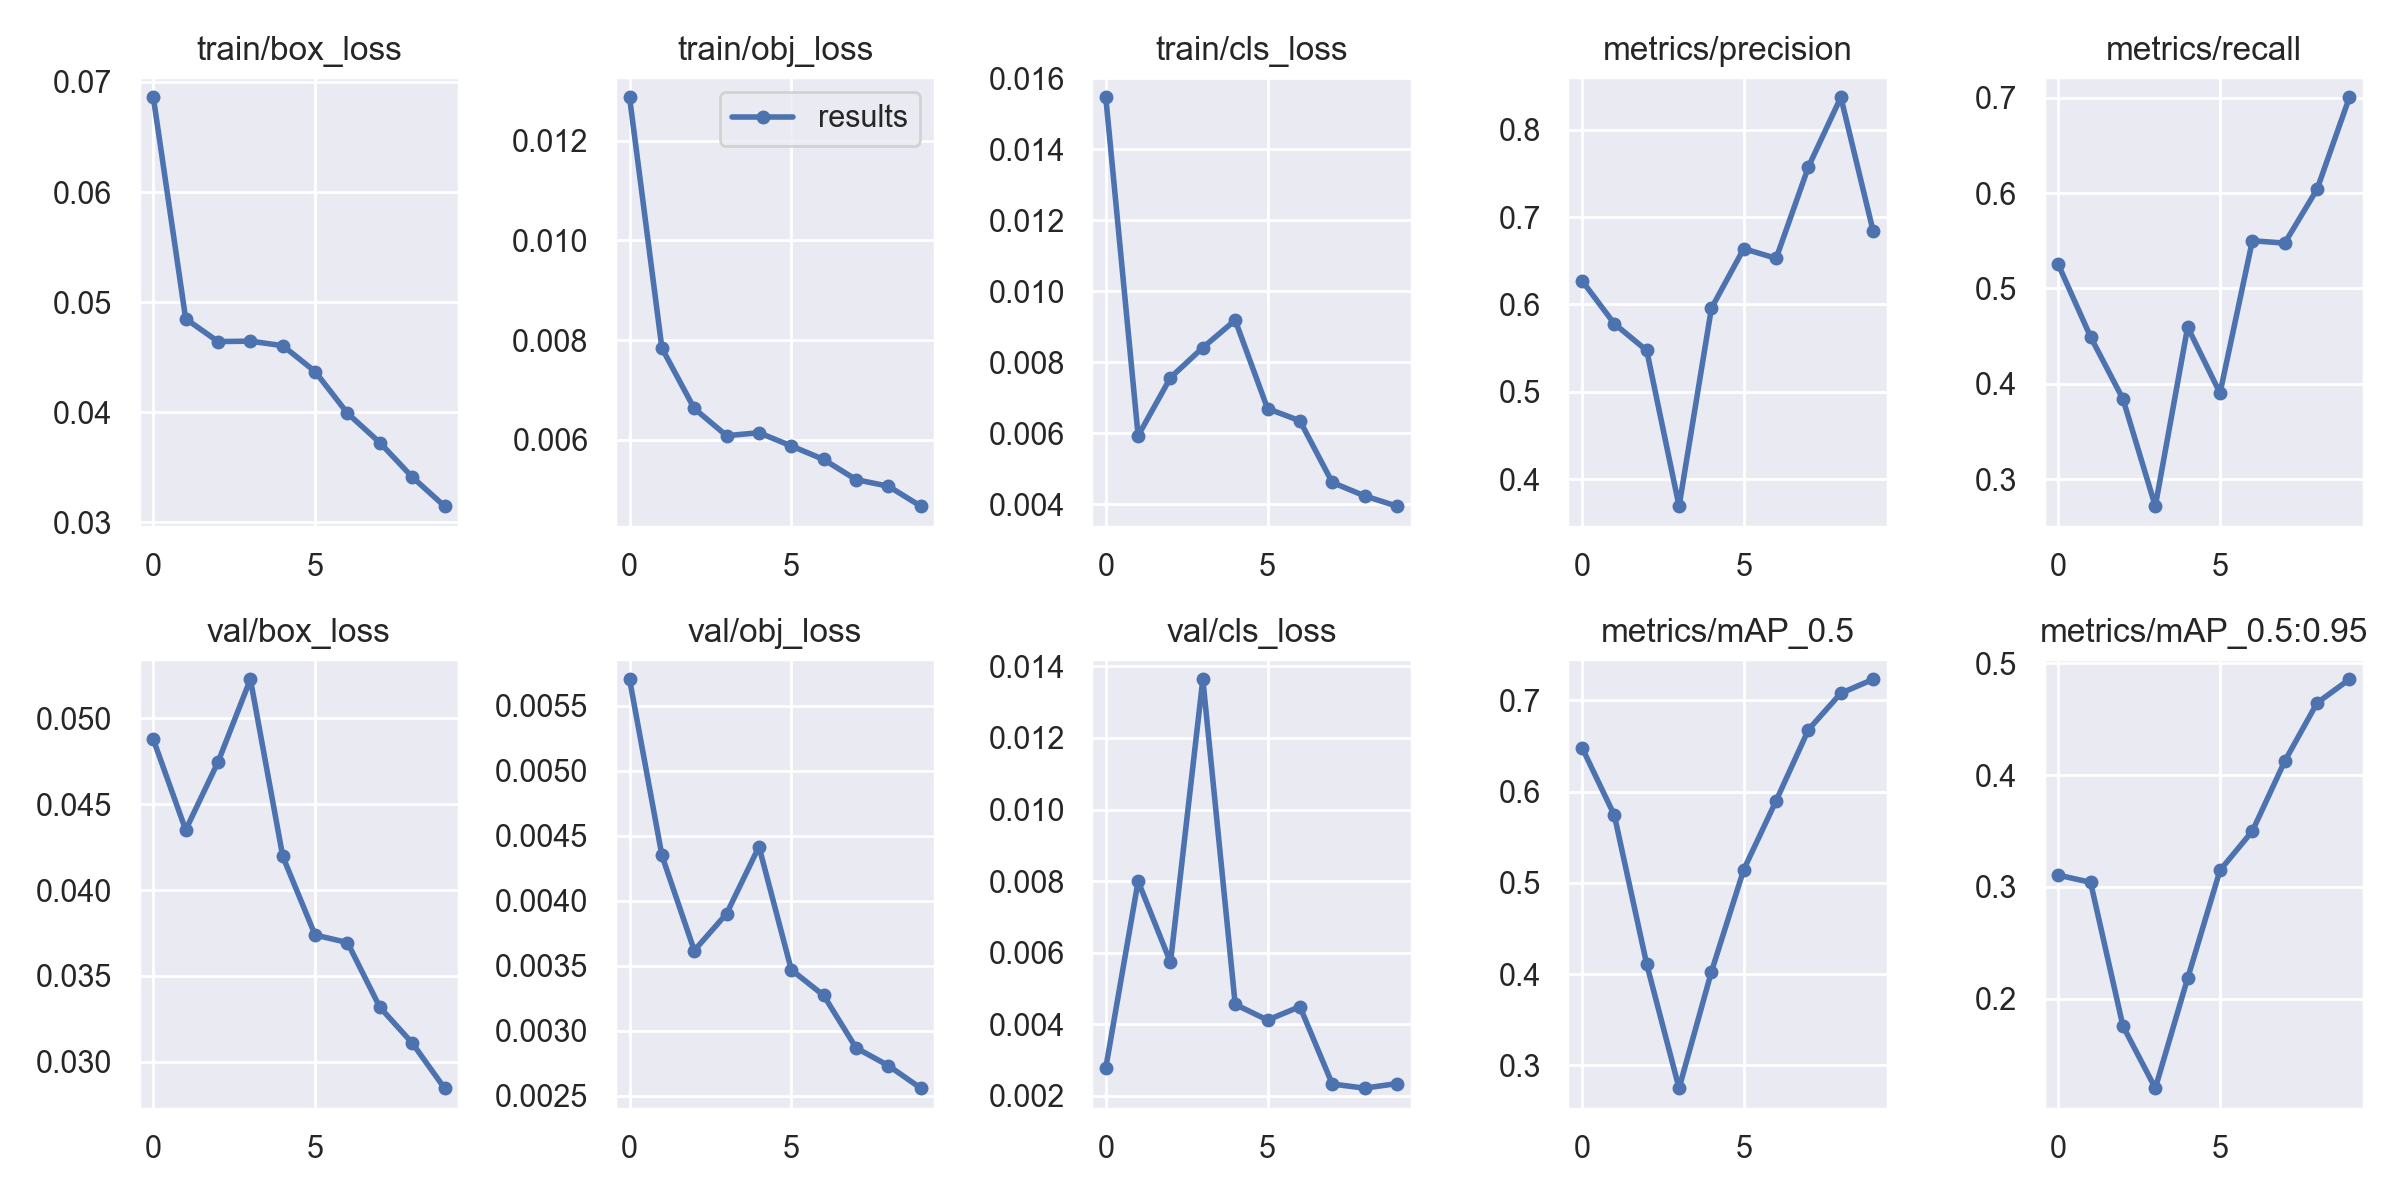
验证图片集: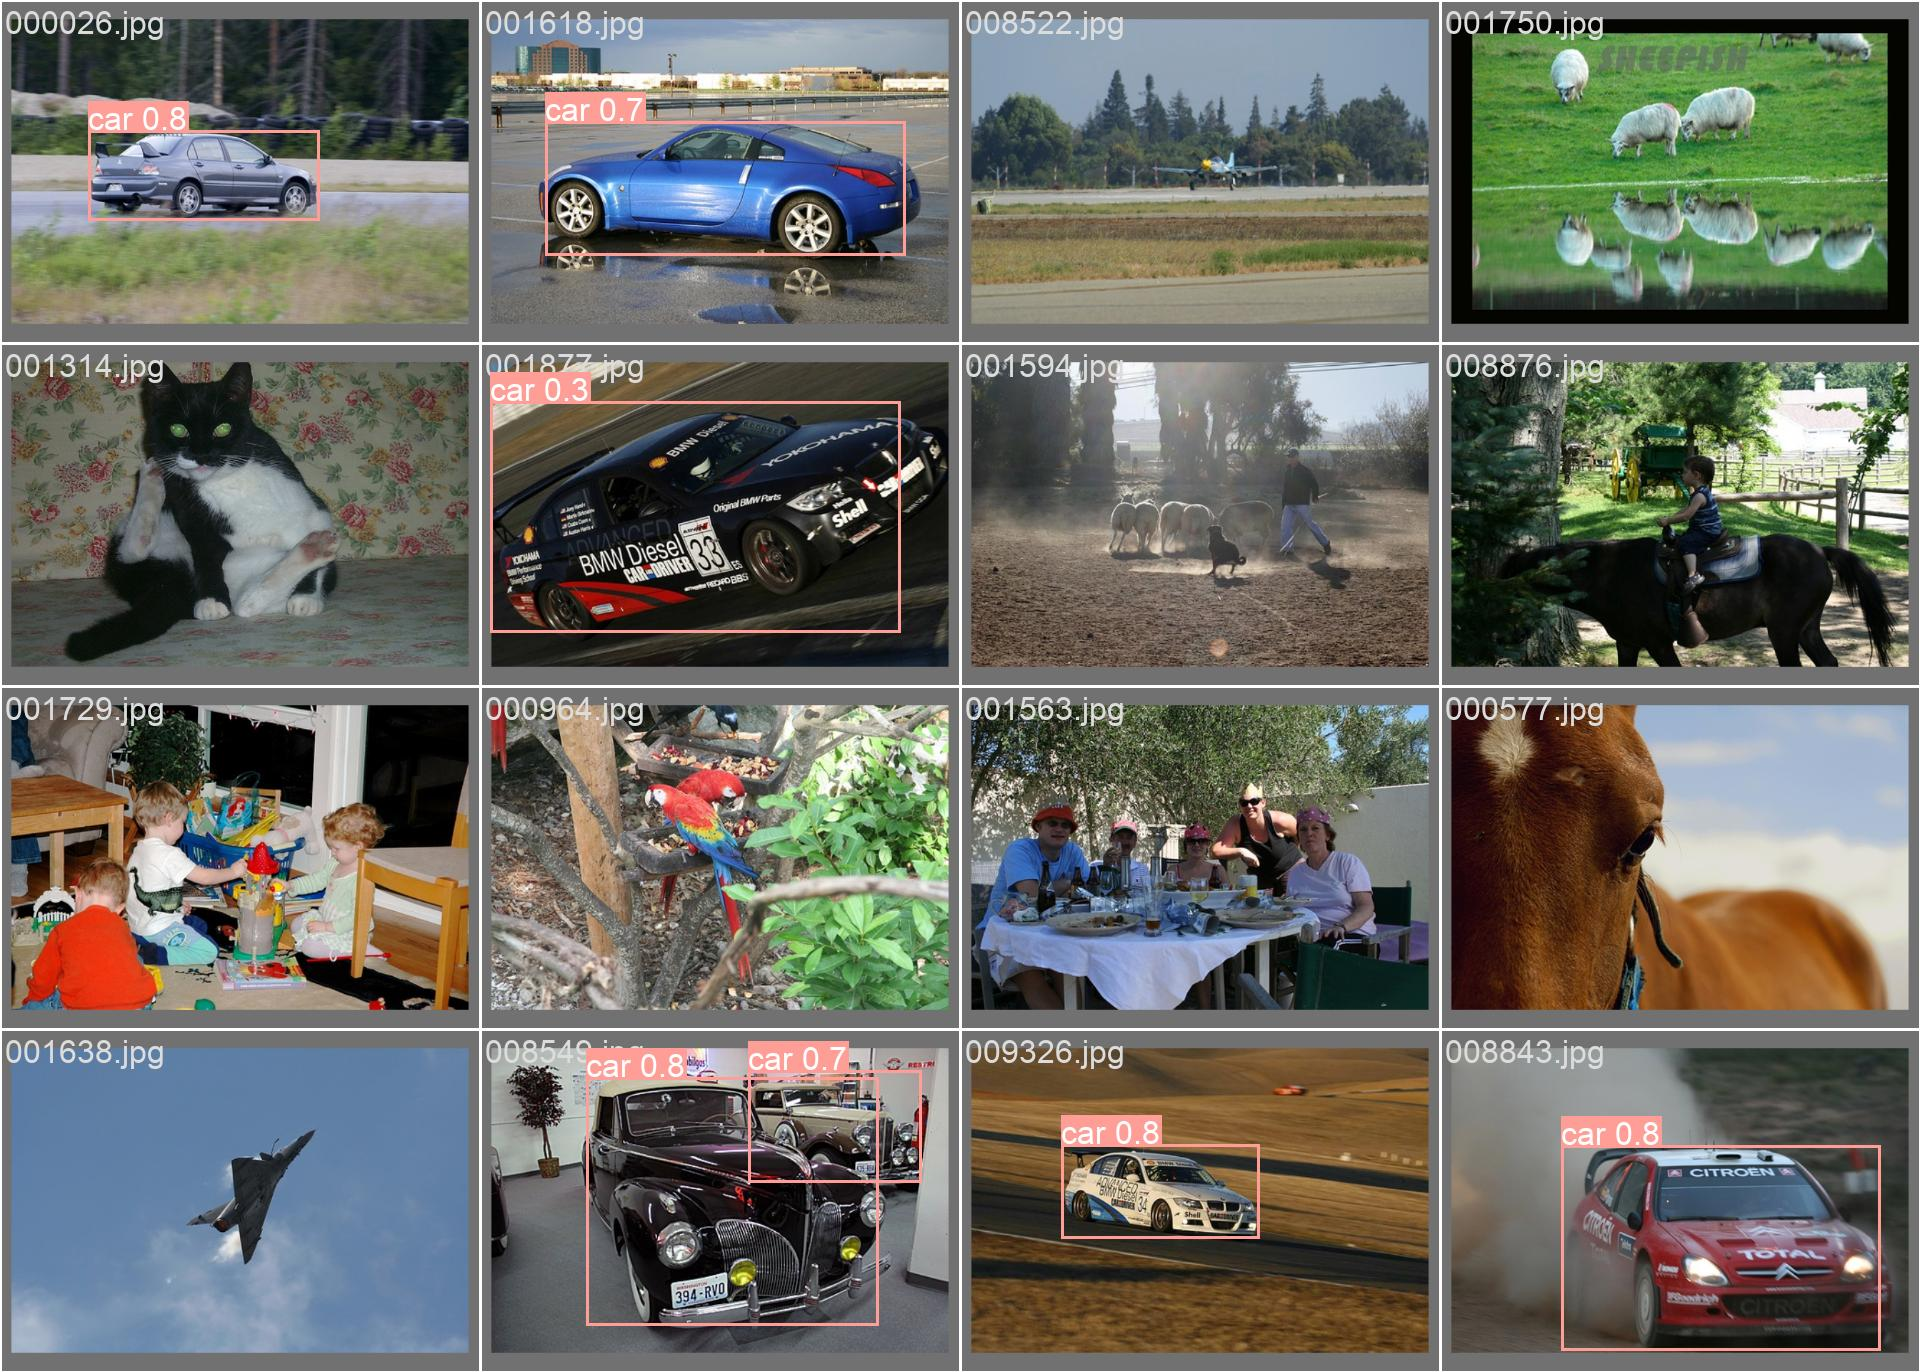
    

## 模型预测
修改detect.py的部分参数:<p>
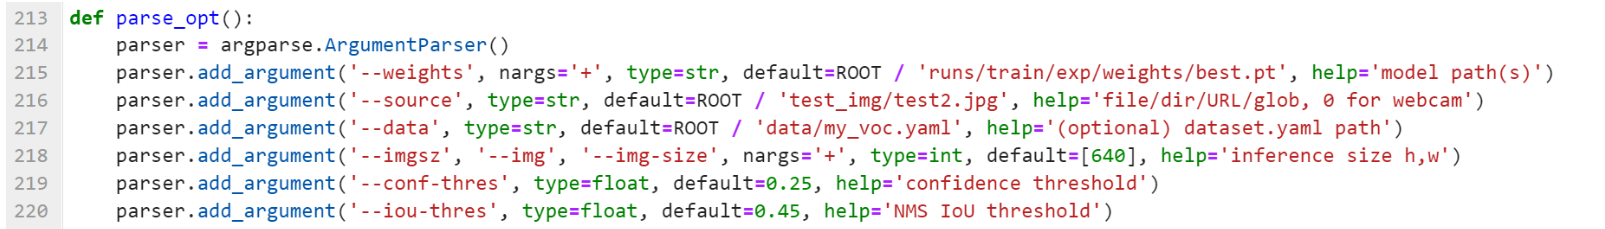
这部分是必要改的,其他的参数可自行搜索其作用并进行修改。<p>
***weight***  修改成训练好的模型地址<p>
***data*** 修改成训练集对应的yaml配置文件<p>
***source*** 修改成测试图片或视频的地址。

In [11]:
!python detect.py --source test_img/test1.jpg 
!python detect.py --source test_img/test2.jpg 

detect: weights=runs/train/exp/weights/best.pt, source=test_img/test1.jpg, data=data/my_voc.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
default message here: Python 3.7.0 required by YOLOv5, but Python 3.6.2 is currently installed
YOLOv5 🚀 9ed42e0 Python-3.6.2 torch-1.9.0+cu102 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients
image 1/1 /data/workspace/myshixun_tpm284289/bnzurlkf/test_img/test1.jpg: 480x640 3 cars, 477.5ms
Speed: 0.4ms pre-process, 477.5ms inference, 1.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3
detect: weights=runs/train/exp/weights/best.pt, source=test_img/test2.jpg, data=data/my_voc.yaml,

**检测结果保存在此文件夹下：**

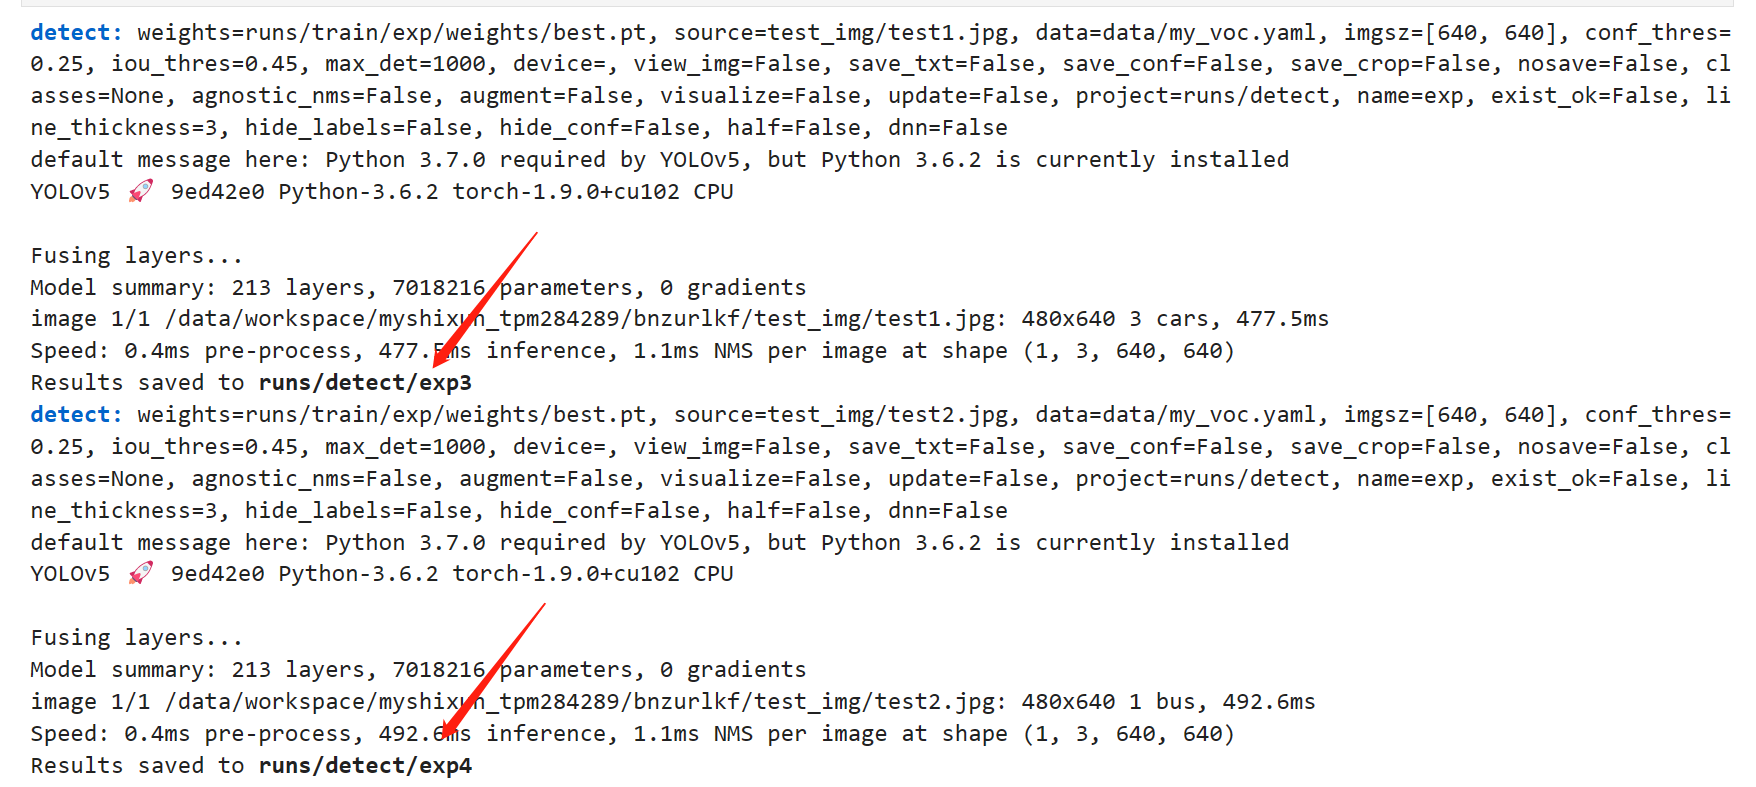

运行下述代码展示检测效果：

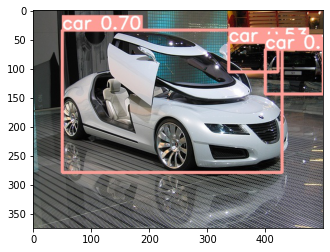

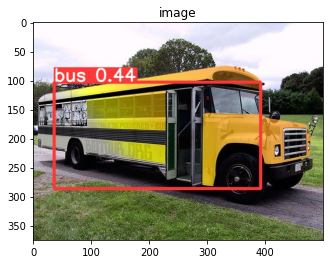

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
 
# 图片路径
img_car = Image.open("runs/detect/exp3/test1.jpg")
img_people = Image.open("runs/detect/exp4/test2.jpg")
plt.imshow(img_car)
plt.show()

plt.imshow(img_people)
plt.axis('on')  # 关掉坐标轴为 off
plt.title('image')  # 图像题目
plt.show()